# TerraFirma UKESM long-term stabilisation and overshoot scenarios

--> all discussion points are here: https://docs.google.com/presentation/d/1SOaZNC75PjgijUn1iw4DD243Cmnwmu65ckTgtNKCRp0/edit


#### TODO -_> update the text here below ... 
- decide how the bias correction should be applied
    - according to Tom Mitcham: simulation years 10 to 50 of the ramp-up phase are most equal to 1975-2025 in terms of warming trend
          - global mean temperature is similar (+0.26°C), but there is another period (simulation year 0 to 40 which would fit better
    - [ ] double-checked the warming trend?
- [ ] create a `process_terrafirma_ukesm_data()`,
- [ ] test with HEF using W5E5 or ERA5, RGI7?, regional spinup ...
        - do they need that we start from pre-industrial state, or would it be ok, if we just start at simulation year 30 (which would correspond best to a "climate" as we had around year 2000, which is around RGI/glavier volume inventory year ... I guess the problem is that their ice sheet / sea-level rise output will be relative to "pre-industrial", and therefore, we also need the glaciers to have the "pre-industrial" baseline...? 
- [ ] do I need to do sth. about the growing out of border issue ...https://github.com/OGGM/oggm/issues/1822 
          

In [1]:
import xarray as xr
xr.set_options(use_new_combine_kwarg_defaults=True)
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 24
from func_add_terrafirma import scenarios, color_scenario, ls_scenario, ls_scenario_tuple

- "esm-up2p0" is the "ramp-up" phase.
- "esm-up2p0-gwl2p0" is stabilisation at 2C 
- "esm-up2p0-gwl2p0-50y-dn2p0" is a "ramp-down" from the 2C stabilisation after 50 years'
- "esm-up2p0-gwl2p0-50y-dn1p0" is a "ramp-down" from the 2C stabilisation after 50 years', slower cooling rate 
- "esm-up2p0-gwl3p0" is stabilisation at 3C 
- "esm-up2p0-gwl3p0-50y-dn2p0" is a "ramp-down" from the 3C stabilisation after 50 years'
- "esm-up2p0-gwl4p0" is stabilisation at 4C
- "esm-up2p0-gwl4p0-50y-dn2p0" is a "ramp-down" from the 4C stabilisation after 50 years'
- "esm-hist" is the same model (UKESM1.2-LL) being forced through the CMIP historical forcing'
- "esm-piControl" is the same model with pre-industrial forcing'

In [2]:
ls_scenario["up2p0-gwl2p0-50y-dn1p0"] = '--'
ls_scenario["up2p0-gwl3p0-50y-dn2p0"] = '--'
ls_scenario["up2p0-gwl3p0"] = ':'
ls_scenario_tuple["up2p0-gwl2p0-50y-dn1p0"] = (6, 2)
ls_scenario_tuple["up2p0-gwl3p0-50y-dn2p0"] = (6, 2)
ls_scenario_tuple["up2p0-gwl3p0"] = (1, 2)
color_scenario["up2p0-gwl2p0-50y-dn1p0"] = (0.25, 0.60, 0.35)
color_scenario["up2p0-gwl3p0-50y-dn2p0"] = (0.55, 0.50, 0.18)
color_scenario["up2p0-gwl3p0"] = (0.42, 0.55, 0.25)

In [3]:
scenarios.append("up2p0-gwl2p0-50y-dn1p0")
scenarios.append("up2p0-gwl3p0")
scenarios.append("up2p0-gwl3p0-50y-dn2p0")

In [4]:
variables = ['pr','tas']
time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)


In [5]:
scenarios

['up2p0-gwl4p0-50y-dn2p0',
 'up2p0-gwl4p0',
 'up2p0-gwl2p0-50y-dn2p0',
 'up2p0-gwl2p0',
 'up2p0',
 'hist',
 'up2p0-gwl2p0-50y-dn1p0',
 'up2p0-gwl3p0',
 'up2p0-gwl3p0-50y-dn2p0']

In [6]:
run = False
if run:
    for var in ['tas']: #pr
        time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
        global_var_mean_dict = {}
        for scen in scenarios:
            _dt = xr.open_dataset(f'terrafirma_data/{var}_Amon_UKESM1-2-LL_esm-{scen}_r1i1p1f1_gn.nc',
                                 decode_times=time_coder).groupby('time.year').mean().load()
            ### check the global mean temperature and precipitation time series
            # weighted average over latitudes
            if var == 'tas':
                _dt[var] = _dt[var]-273.15
            weight = np.cos(np.deg2rad(_dt.lat))
            weight = weight / weight.sum()
            global_var_mean_dict[scen] = (_dt.mean(dim='lon') * weight).sum(dim='lat')
        keys = list(global_var_mean_dict.keys())
        vals = list(global_var_mean_dict.values())

        ds_global_var_mean = xr.concat(vals, dim="scenario", join='outer')
        ds_global_var_mean = ds_global_var_mean.assign_coords(scenario=keys)
        ds_global_var_mean.to_netcdf(f'00a_terrafirma_global_annual_mean_{var}_scenarios.nc')
ds_global_tas_mean = xr.open_dataset('00a_terrafirma_global_annual_mean_tas_scenarios.nc')
ds_global_pr_mean = xr.open_dataset('00a_terrafirma_global_annual_mean_pr_scenarios.nc')

ds_w5e5 = xr.open_dataset('/home/www/oggm/climate/gswp3-w5e5/unflattened/monthly/gswp3-w5e5_obsclim_tas_global_monthly_1901_2019.nc')
ds_w5e5 = ds_w5e5.groupby('time.year').mean().load()
ds_w5e5['tas'] = ds_w5e5['tas'] -273.15
weight = np.cos(np.deg2rad(ds_w5e5.lat))
weight = weight / weight.sum()
ds_global_tas_mean_w5e5 = (ds_w5e5.mean(dim='lon') * weight).sum(dim='lat')

##### average global mean temperature during reference period relatively similar

In [5]:
ds_global_tas_mean_w5e5.sel(year=slice(1975,2014)).mean().tas.values

array(14.19233131)

In [6]:
ds_global_tas_mean.sel(year=slice(1850,1889)).mean('year').sel(scenario='up2p0').tas.values

array(14.23711727)

In [7]:
ds_global_tas_mean.sel(year=slice(1975,2014)).mean('year').sel(scenario='hist').tas.values

array(14.23807882)

#### check std differences

In [8]:
# ... 
std_ref_period_hist_w5e5 = ds_global_tas_mean_w5e5.sel(year=slice(1975,2014)).std().tas.values
# standard deviation up2p0 ramp-up 
std_ref_period_up2p0 = ds_global_tas_mean.sel(scenario='up2p0').sel(year=slice(1850,1889)).std().tas.values
# standard deviation historical  
std_ref_period_hist_ukesm = ds_global_tas_mean.sel(scenario='hist').sel(year=slice(1975,2014)).std().tas.values
print(std_ref_period_hist_w5e5/std_ref_period_hist_ukesm, 
      std_ref_period_hist_ukesm/std_ref_period_hist_ukesm,
      std_ref_period_up2p0/std_ref_period_hist_ukesm)

0.5416458469974431 1.0 0.8765755454417312


#### check spatial differences

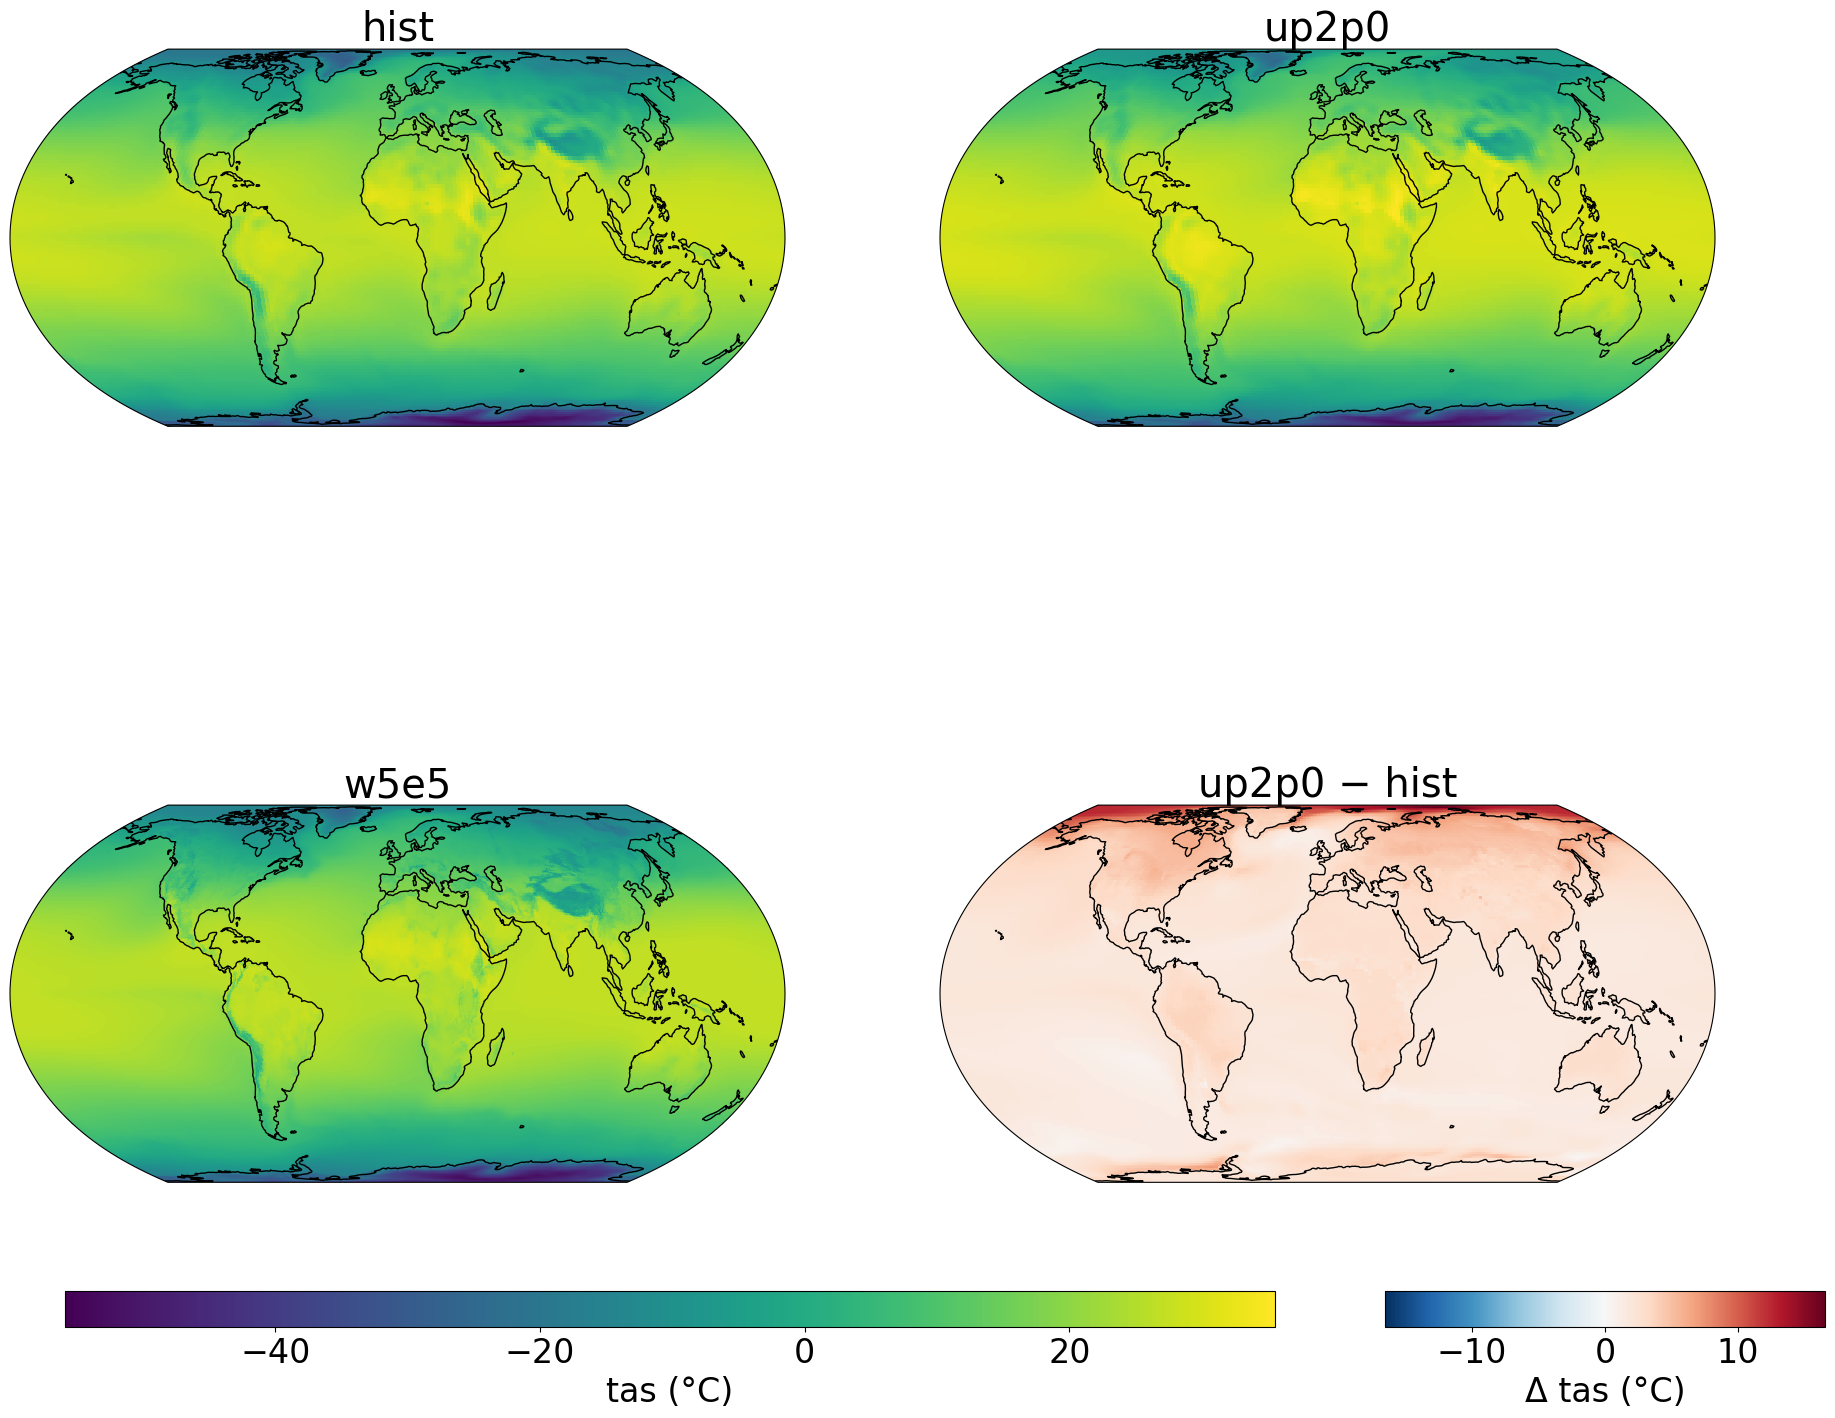

In [33]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import numpy as np

var = "tas"
_scenarios = ["hist", "up2p0", "w5e5"]
years = slice('1975-01', '2014-12')
years = slice('1975', '2014')

# LOAD DATA ONCE
ds_hist = xr.open_dataset(
    "terrafirma_data/tas_Amon_UKESM1-2-LL_esm-hist_r1i1p1f1_gn.nc",
    decode_times=time_coder)

ds_up2p0 = xr.open_dataset(
    "terrafirma_data/tas_Amon_UKESM1-2-LL_esm-up2p0_r1i1p1f1_gn.nc",
    decode_times=time_coder)

# PRECOMPUTE CLIMATOLOGIES (AVOID REPEATED GROUPBY)
dt_hist = ds_hist.sel(time=years).mean("time") - 273.15
dt_up2p0 = ds_up2p0.sel(time=years).mean("time") - 273.15
dt_w5e5_n = ds_w5e5.sel(year=years).mean("year")

dt = {
    "hist": dt_hist,
    "up2p0": dt_up2p0,
    "w5e5": dt_w5e5_n,
}

# -------------------------------------------------
# FIGURE (leave room at bottom)
# -------------------------------------------------
fig, axes = plt.subplots(
    2, 2,
    figsize=(22, 18),
    subplot_kw=dict(projection=ccrs.EqualEarth()),
    constrained_layout=False
)
axes = axes.flatten()

# -------------------------------------------------
# SHARED COLOR SCALE (FIRST THREE)
# -------------------------------------------------
vmin = min(dt[scen][var].min().item() for scen in _scenarios[:3])
vmax = max(dt[scen][var].max().item() for scen in _scenarios[:3])
norm_main = colors.Normalize(vmin=vmin, vmax=vmax)

# -------------------------------------------------
# FIRST THREE PANELS
# -------------------------------------------------
mappables = []
for j, scen in enumerate(_scenarios[:3]):
    ax = axes[j]

    m = dt[scen][var].plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        norm=norm_main,
        cmap="viridis",
    )
    mappables.append(m)

    ax.coastlines(resolution="110m")
    ax.set_title(scen)

# -------------------------------------------------
# DIFFERENCE PANEL
# -------------------------------------------------
ax = axes[3]
diff = dt["up2p0"] - dt["hist"]

vmax_diff = np.abs(diff[var]).max().item()
norm_diff = colors.TwoSlopeNorm(vmin=-vmax_diff, vcenter=0, vmax=vmax_diff)

m_diff = diff[var].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    norm=norm_diff,
    add_colorbar=False,
)

ax.coastlines(resolution="110m")
ax.set_title("up2p0 − hist")

# -------------------------------------------------
# MANUAL COLORBAR AXES (THIS IS THE FIX)
# -------------------------------------------------

# First colorbar: under top row, centered
cax1 = fig.add_axes([0.15, 0.10, 0.55, 0.02])  # [left, bottom, width, height]
cbar1 = fig.colorbar(mappables[0], cax=cax1, orientation="horizontal")
cbar1.set_label(f"{var} (°C)")

# Second colorbar: under bottom-right panel
cax2 = fig.add_axes([0.75, 0.10, 0.20, 0.02])
cbar2 = fig.colorbar(m_diff, cax=cax2, orientation="horizontal")
cbar2.set_label(f"Δ {var} (°C)")

# -------------------------------------------------
# FINALIZE
# -------------------------------------------------
plt.savefig(
    "00a_spatial_temp_distribution_scenarios_ref_period.png",
    dpi=200,
    bbox_inches="tight",
)
plt.show()


In [8]:
from scipy.stats import linregress
from scipy.stats import theilslopes

ref_period_1975_2014_linear_fit_slope = {}
ref_period_1975_2014_theil_sen_slope = {}
ref_period_1975_2014 = {}

tas_ann_hist_ref = ds_global_tas_mean.sel(scenario='hist').sel(year=slice(1975,2014)).tas
tas_ann_hist_ref_w5e5 = ds_global_tas_mean_w5e5.sel(year=slice(1975,2014)).tas
for clim,tas_ann in zip(['ukesm','w5e5'],[tas_ann_hist_ref, tas_ann_hist_ref_w5e5]):
    t = tas_ann.year
    y = tas_ann.values
    res = linregress(t, y)        
    ts = theilslopes(y, t)
    ref_period_1975_2014_linear_fit_slope[clim] = res.slope
    ref_period_1975_2014_theil_sen_slope[clim] = ts[0]
    print("linear fit slope °C/year:", res.slope, ", Theil–Sen slope °C/year:", ts[0])
    #print("95% CI lower:", ts[2])
    #print("95% CI upper:", ts[3])
    ref_period_1975_2014[clim] = ds_global_tas_mean.sel(scenario='hist').tas.sel(year=slice(1975,2014)).mean()

linear fit slope °C/year: 0.028984237786977774 , Theil–Sen slope °C/year: 0.030282438500246388
linear fit slope °C/year: 0.015638603904681178 , Theil–Sen slope °C/year: 0.015558769124420294


In [9]:
import pandas as pd
pd_linear_fit = pd.DataFrame()
for j in np.arange(0,250):
    tas_ann = ds_global_tas_mean.sel(scenario='up2p0').tas.sel(year=slice(1850+j,1889+j))
    t = tas_ann.year
    y = tas_ann.values
    res = linregress(t, y)        
    ts = theilslopes(y, t)
    pd_linear_fit.loc[j+1850+40,'linear fit slope'] = res.slope
    pd_linear_fit.loc[j+1850+40, 'Theil-Sen slope'] = ts[0]
    pd_linear_fit.loc[j+1850+40, 'global_mean_temp'] = tas_ann.mean().values


In [10]:
rolling_40yr_ramp = ds_global_tas_mean.sel(scenario='up2p0').tas.rolling(year=40, center=False).mean().dropna(dim='year') - ref_period_1975_2014['ukesm']
year_match = np.abs(rolling_40yr_ramp).idxmin()
year_match-1850
# when just checking the global average temperature using 1850 to 1889 works best,

<xarray.DataArray 'year' ()> Size: 8B
array(39.)
Coordinates:
    height   float64 8B 1.5

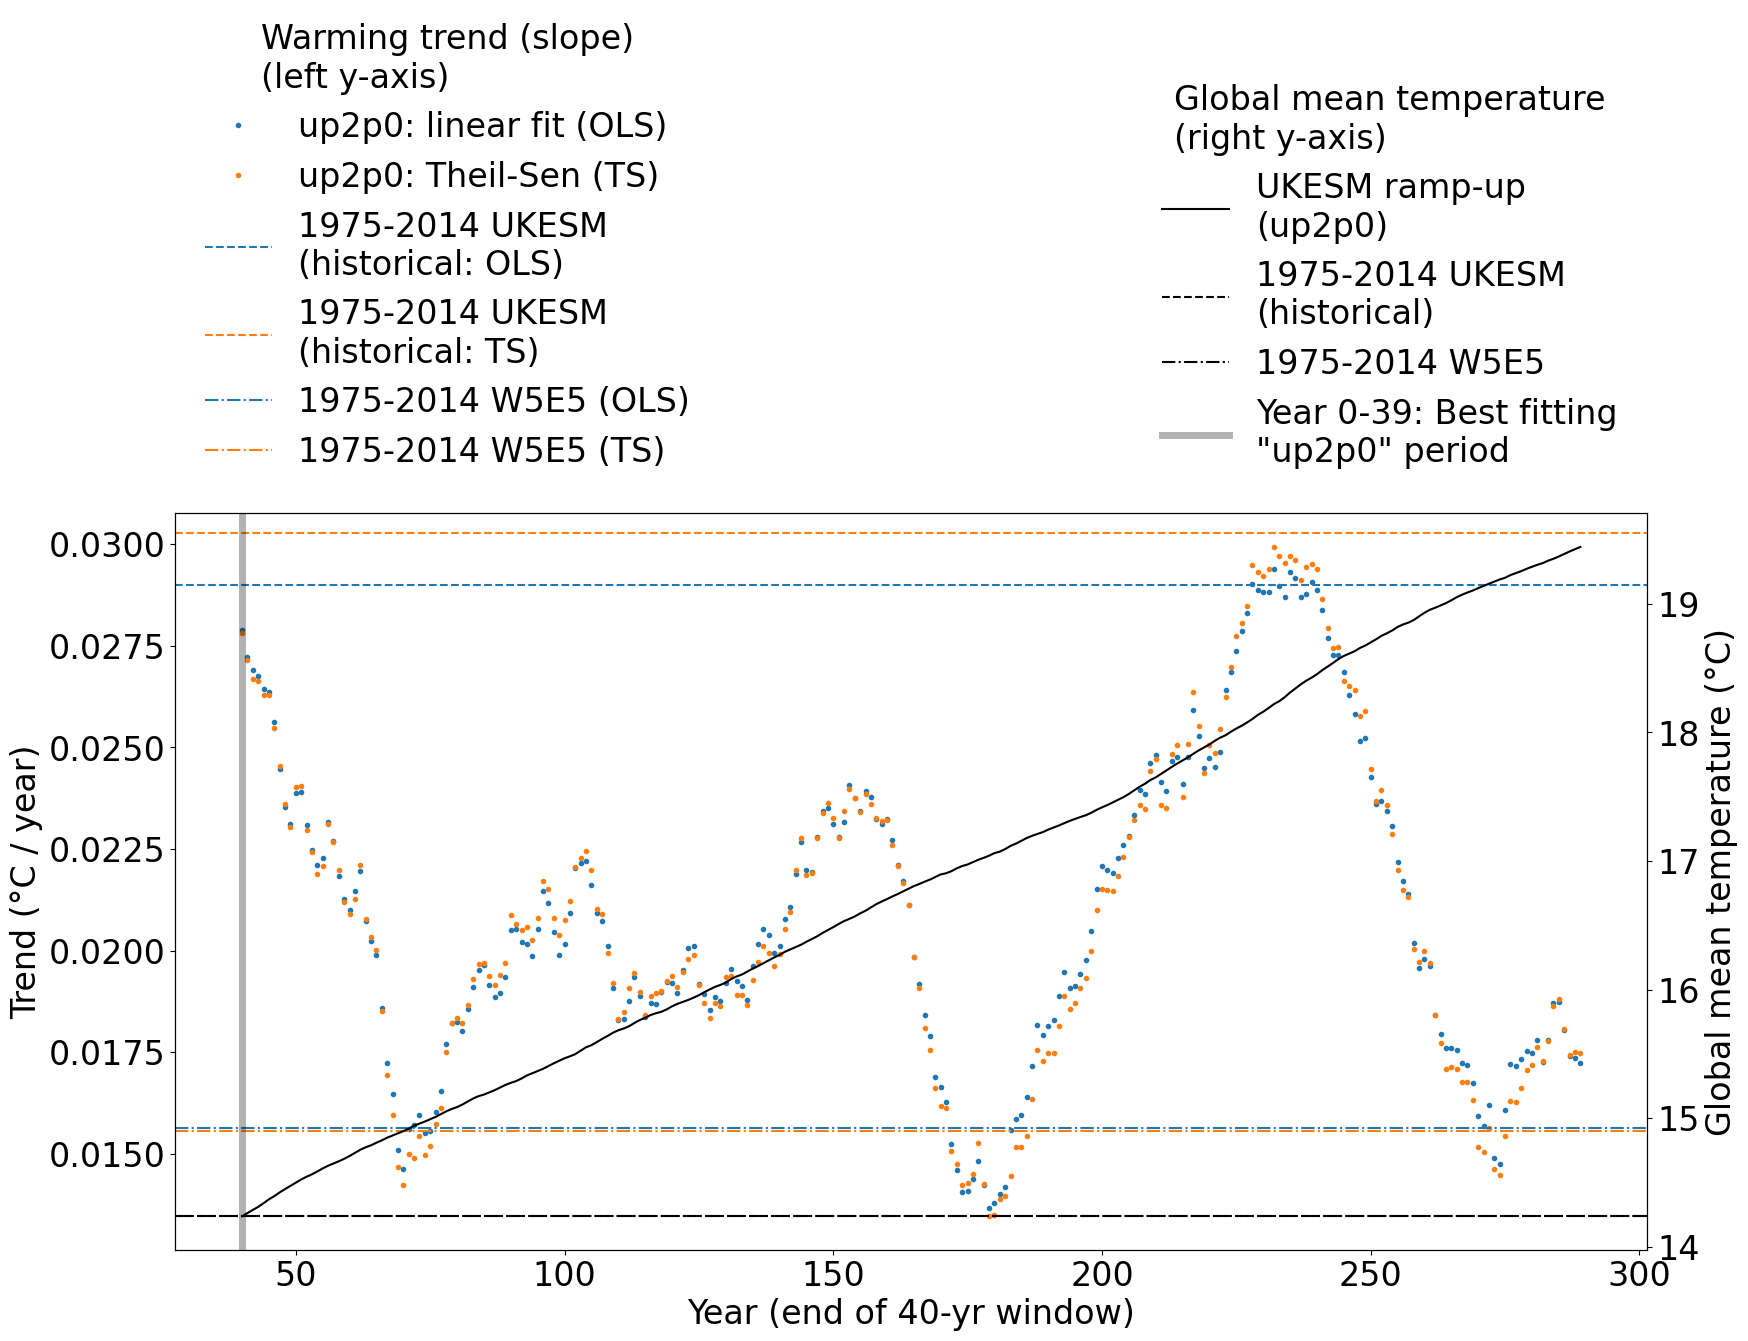

In [15]:
plt.rcParams["font.size"] = 24
plt.figure(figsize=(18,14))
ax = plt.gca()
# ----- primary axis -----
ax.plot(pd_linear_fit.index-1850, pd_linear_fit['linear fit slope'],
        '.', label='up2p0: linear fit (OLS)')
ax.plot(pd_linear_fit.index-1850, pd_linear_fit['Theil-Sen slope'],
        '.', label='up2p0: Theil-Sen (TS)')

ax.axhline(ref_period_1975_2014_linear_fit_slope['ukesm'], color='C0',
           ls='--', label='1975-2014 UKESM\n(historical: OLS)')
ax.axhline(ref_period_1975_2014_theil_sen_slope['ukesm'], color='C1',
           ls='--', label='1975-2014 UKESM\n(historical: TS)')

ax.axhline(ref_period_1975_2014_linear_fit_slope['w5e5'], color='C0',
           ls='-.', label='1975-2014 W5E5 (OLS)')
ax.axhline(ref_period_1975_2014_theil_sen_slope['w5e5'], color='C1',
           ls='-.', label='1975-2014 W5E5 (TS)')

ax.set_xlabel('Year (end of 40-yr window)')
ax.set_ylabel('Trend (°C / year)')

# ----- secondary axis -----
ax2 = ax.twinx()
l2, = ax2.plot(pd_linear_fit.index-1850, pd_linear_fit['global_mean_temp'], '-', color='k',
               label='UKESM ramp-up\n(up2p0)')
ax2.axhline(ref_period_1975_2014['ukesm'], ls='--', color='k', label='1975-2014 UKESM\n(historical)')
ax2.axhline(ref_period_1975_2014['w5e5'].values,
            ls='-.', color='k', label='1975-2014 W5E5')

ax2.axvline(40, ls='-',label='Year 0-39: Best fitting\n"up2p0" period', alpha=0.3, lw=5, color='k')
ax2.set_ylabel('Global mean temperature (°C)')

# ---- legend for primary axis (top-left, outside) ----
ax.legend(title='Warming trend (slope)\n(left y-axis)',
    loc='lower left',
    bbox_to_anchor=(0, 1.02),
    ncol=1,
    frameon=False
)

# ---- legend for secondary axis (top-right, outside) ----
ax2.legend(title='Global mean temperature\n(right y-axis)',
    loc='lower right',
    bbox_to_anchor=(1, 1.02),
    frameon=False
)

plt.tight_layout()
plt.savefig('00a_terrafirma_warming_trend.png')

- trend with OLS (linear fit) is lower than with Theil-Sen, meaning that there are some negative outliers in the "historical" UKESM. Those outliers are not visible within the 40-year ramp-up period or the W5E5 climate

- In my opinion, year 0 to end of 39 of the ramp up scenario (up2p0) fits best to the historical 1975-2014 period in terms of both, the warming trend and the global mean temperature. However, according to the paper it is year 10 to 50. 

----
- Tom Mitcham: the years 10-50 of the "ramp-up" is nearest to the years 1975-2015 of the "esm-hist" simulation, at least when comparing global average warming across a set time-period compared to the pre-industrial simulation.
- referred paper: "We therefore compare the evolution of the UKESM1.2 CMIP6 historical runs and the TIPMIP ramp-up runs over a common GMSAT space, namely for the 40-year period of observed warming from 0.2°C to 1.0°C and the same 40-year warming period in the ramp-up run. This equates to 1975 to 2015 in the historical runs and years 10 to 50 of the TIPMIP ramp-up."
---

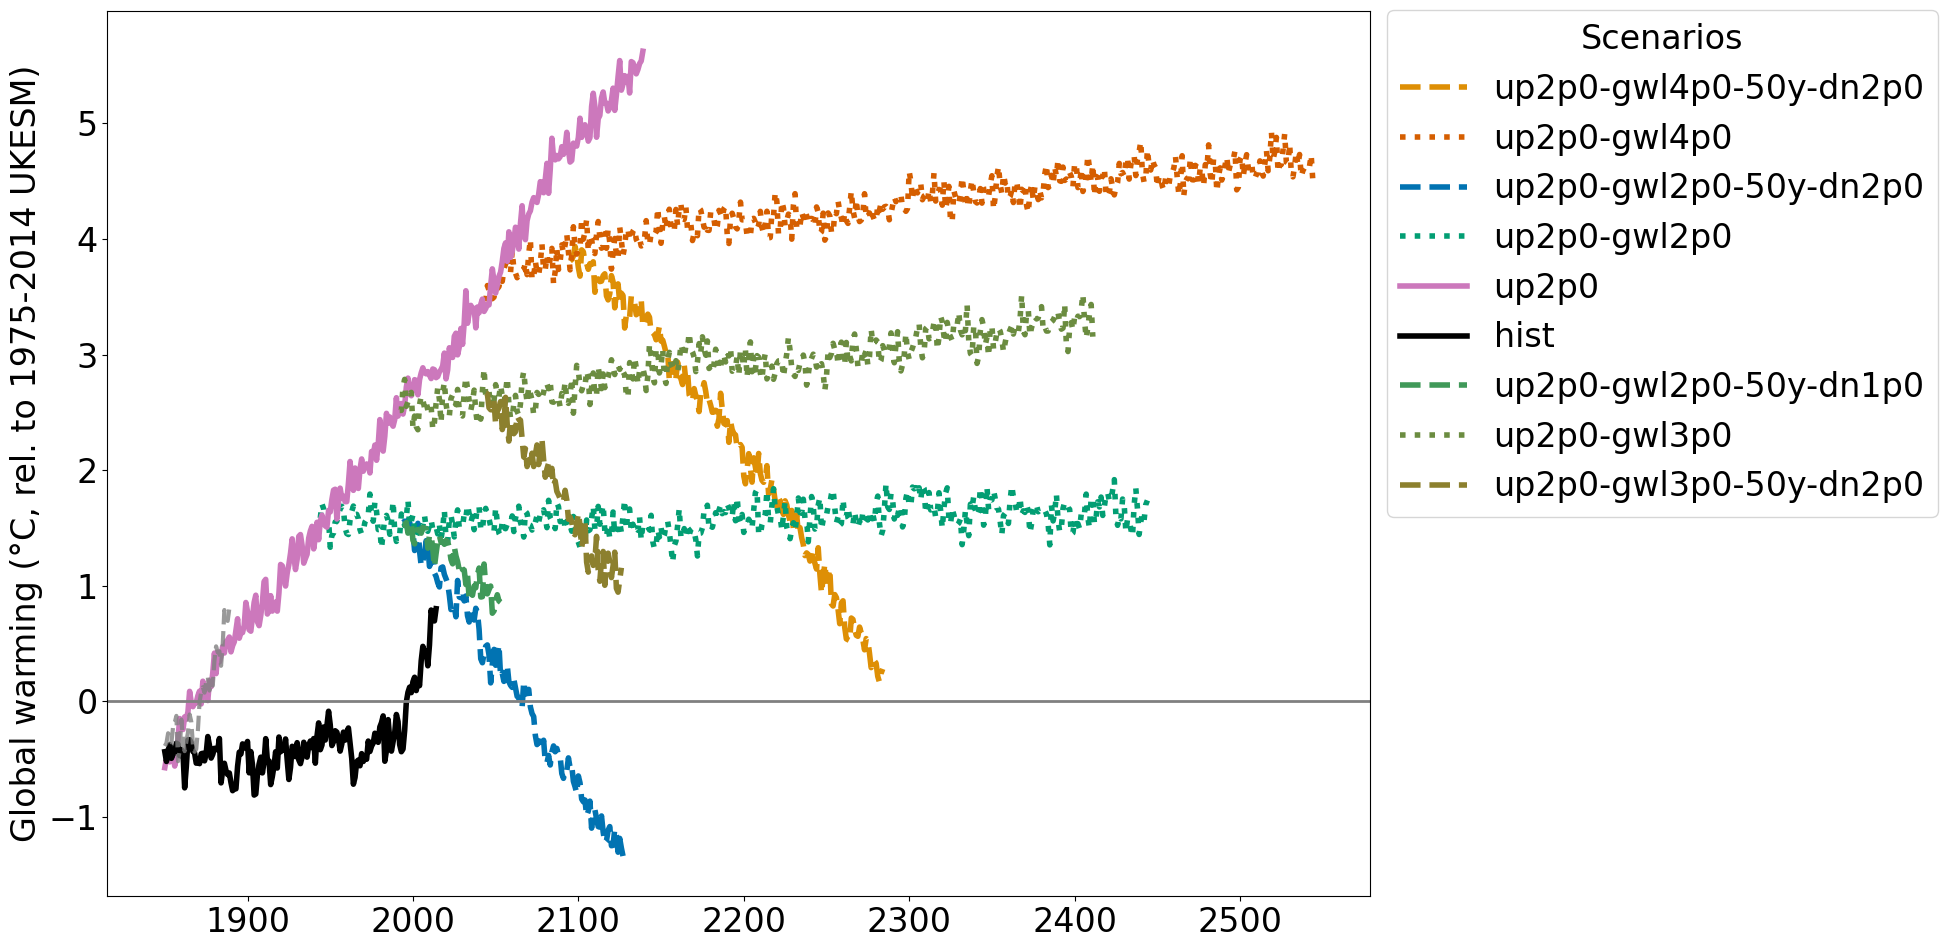

In [12]:
plt.rcParams["font.size"] = 24
plt.figure(figsize=(20,10))
for scen in scenarios: 
    plt.plot(ds_global_tas_mean.sel(scenario=scen).year, 
             ds_global_tas_mean.sel(scenario=scen).tas-ref_period_1975_2014['ukesm'],
             color=color_scenario[scen],ls=ls_scenario[scen], lw=4,
             label=scen)
plt.plot(np.arange(1850,1890,1),
         ds_global_tas_mean.sel(scenario='hist').tas.sel(year=slice(1975,2014))-ref_period_1975_2014['ukesm'],
         color='grey',ls=ls_scenario[scen], lw=3, alpha =0.8)
plt.axhline(0, lw=2, color='grey')
plt.legend(title = 'Scenarios', bbox_to_anchor=(1, 1.02))
plt.ylabel('Global warming (°C, rel. to 1975-2014 UKESM)')
plt.tight_layout()
plt.savefig('00a_terrafirma_global_warming_scenarios_additional_scenarios.png')

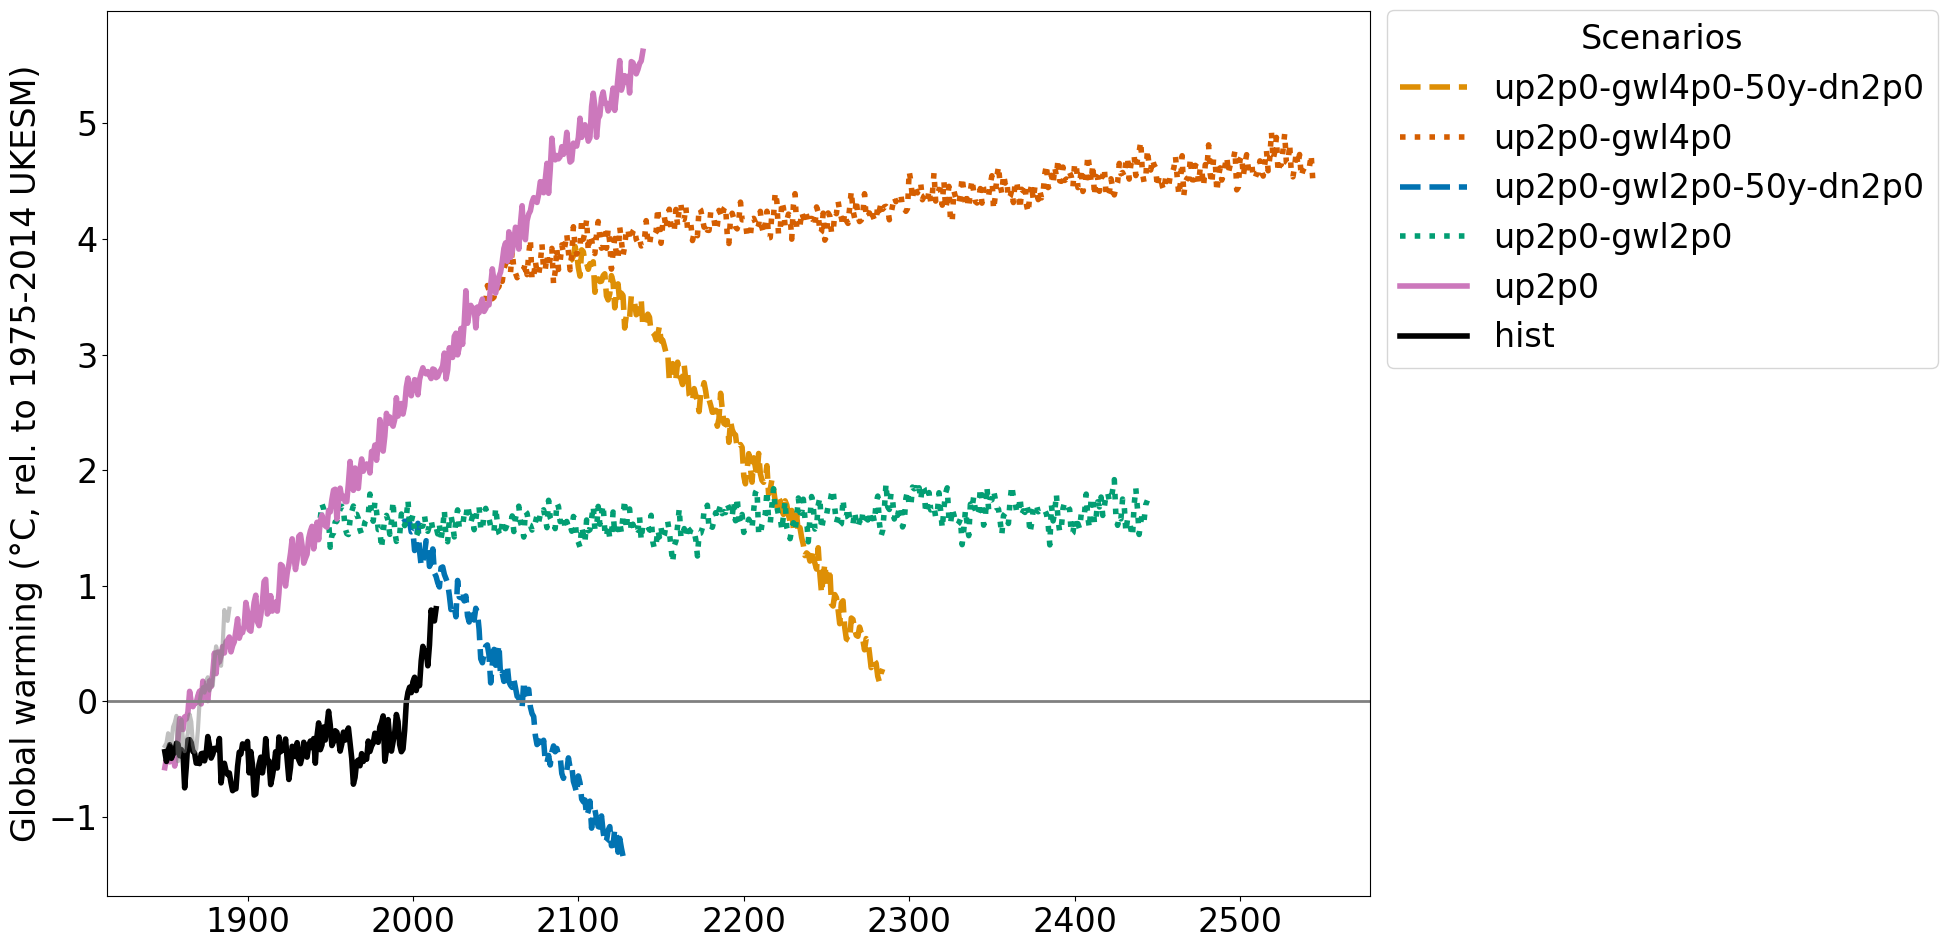

In [53]:
plt.rcParams["font.size"] = 24
plt.figure(figsize=(20,10))
for scen in scenarios: 
    plt.plot(ds_global_tas_mean.sel(scenario=scen).year, 
             ds_global_tas_mean.sel(scenario=scen).tas-ref_period_1975_2014['ukesm'],
             color=color_scenario[scen],ls=ls_scenario[scen], lw=4,
             label=scen)
plt.plot(np.arange(1850,1890,1),
         ds_global_tas_mean.sel(scenario='hist').tas.sel(year=slice(1975,2014))-ref_period_1975_2014['ukesm'],
         color='grey',ls=ls_scenario[scen], lw=3, alpha =0.8)
plt.axhline(0, lw=2, color='grey')
plt.legend(title = 'Scenarios', bbox_to_anchor=(1, 1.02))
plt.ylabel('Global warming (°C, rel. to 1975-2014 UKESM)')
plt.tight_layout()
plt.savefig('00a_terrafirma_global_warming_scenarios.png')

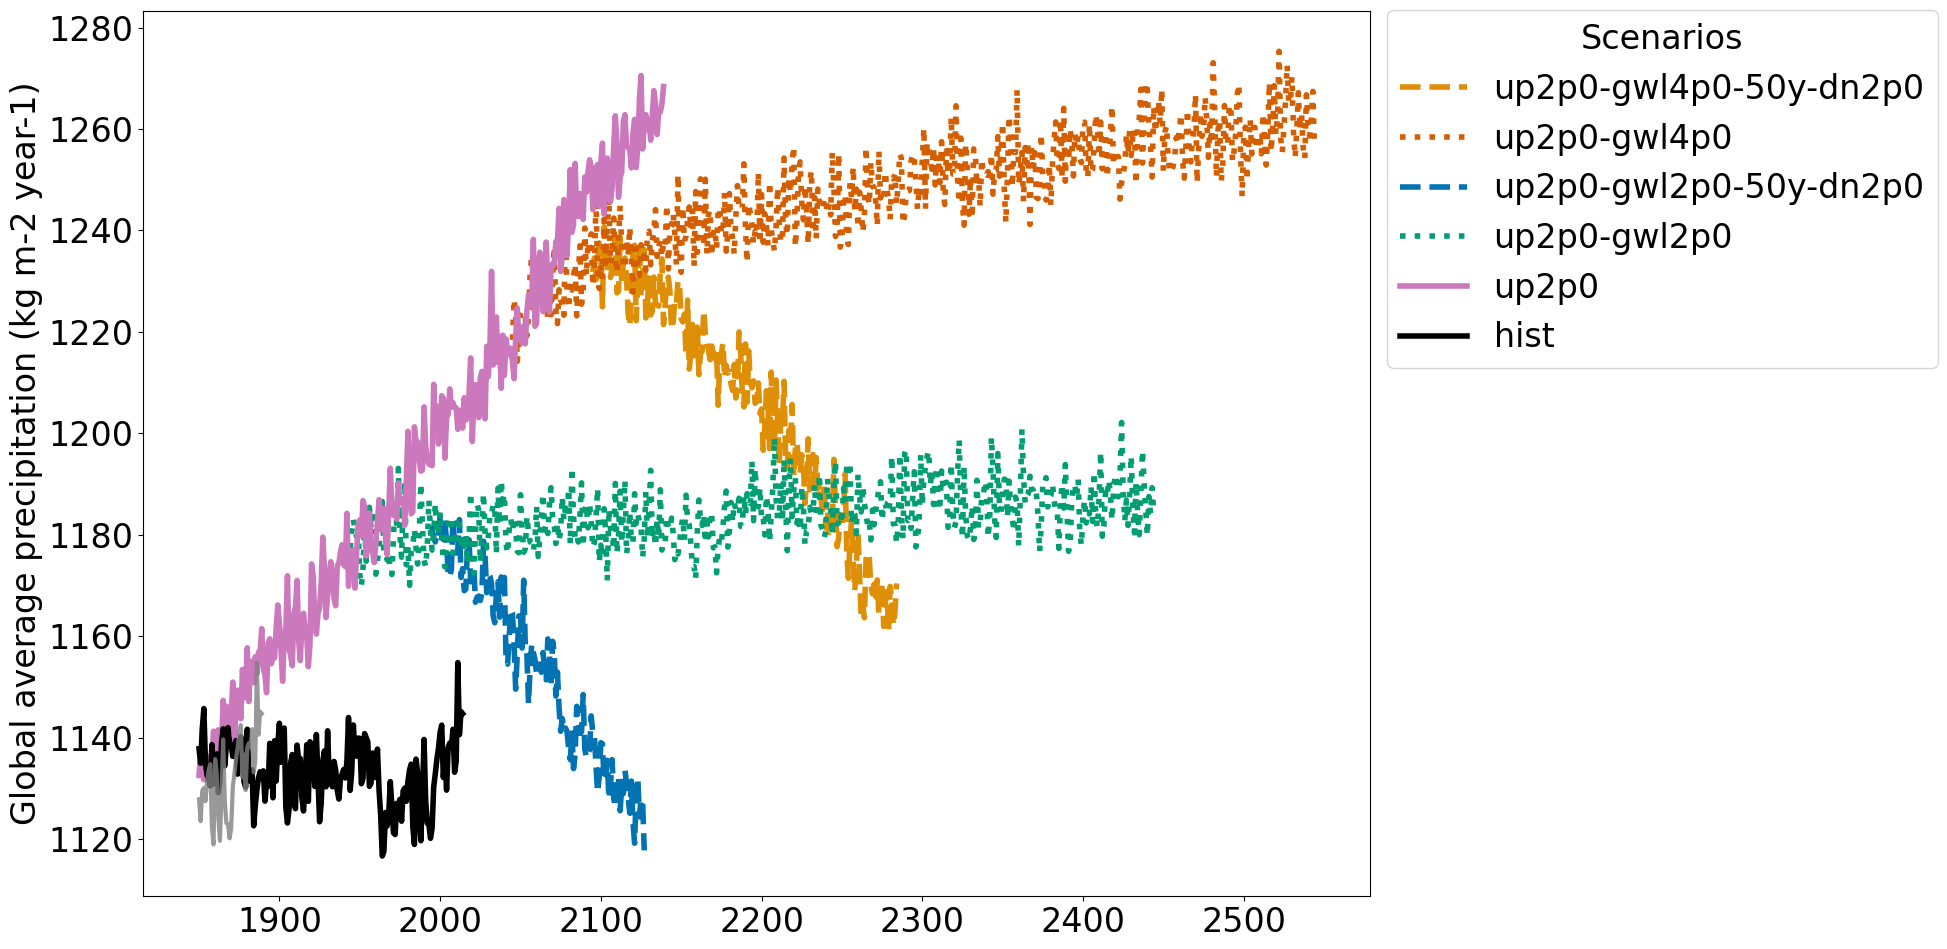

In [54]:
plt.rcParams["font.size"] = 24
plt.figure(figsize=(20,10))
for scen in scenarios: 
    plt.plot(ds_global_pr_mean.sel(scenario=scen).year, 
             ds_global_pr_mean.sel(scenario=scen).pr*365.25*60*60*24,
             color=color_scenario[scen],ls=ls_scenario[scen], lw=4,
             label=scen)
plt.plot(np.arange(1850,1890,1),
         ds_global_pr_mean.sel(scenario='hist').pr.sel(year=slice(1975,2014))*365.25*60*60*24,
         color='grey',ls=ls_scenario[scen], lw=3, alpha =0.8)
#plt.axhline(0, lw=2, color='grey')
plt.legend(title = 'Scenarios', bbox_to_anchor=(1, 1.02))
plt.ylabel('Global average precipitation (kg m-2 year-1)')
plt.tight_layout()
plt.savefig('00a_terrafirma_global_mean_precipitation_scenarios.png')

 - Global average precipitation does not coincide very well to the 1975-2014 historical UKESM precipitation, but we can't really do anything about this...